# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

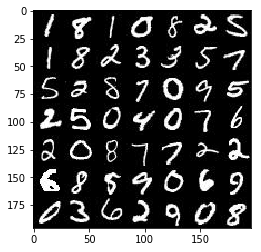

In [2]:
show_n_images = 49

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

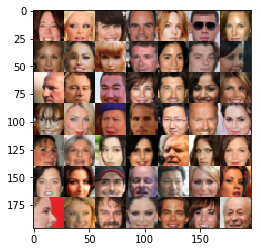

In [3]:
show_n_images = 50

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    t_real_imgs = tf.placeholder( tf.float32, shape=[ None, image_width, image_height, image_channels ], name='real_images' )
    t_z_data    = tf.placeholder( tf.float32, shape=[ None, z_dim ], name='z_input')
    learn_rate  = tf.placeholder( tf.float32, name='learning_rate' )

    return (t_real_imgs, t_z_data, learn_rate)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # Notes:  
    # Build a convolutional neural network
    # 1 fully connected layer at end
    # batch_norm between the layers, except for the first to second
    # no max pool layers
    # downsample is done with stride in conv layers
    # final layer is flattened connected to single sigmoid unit
    # leaky relu activations
    
    #num_units = 128
    alpha     = 0.2
    #drop_rate = 0.5
    # Leveraging code snippets from Intro_to_GANs notebook in the deep-learning repo under gan_mnist folder
    # as well as the DCGAN notebook from the dcgan-svhn folder. Also Rahul Gautam's snippets on discriminator and
    # generator confirmed my suspicion that 3 layers, rather than 2, would likely be needed for good performance,
    # and to try dropout.
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # Input images:  28 x 28 x 3, with pixel values in range -0.5 to 0.5
        img1  = tf.layers.conv2d( images, 64, 4, strides=2, padding='same')
        relu1 = tf.maximum( alpha * img1, img1 )
     #   drop1 = tf.layers.dropout( relu1, drop_rate )
        # 14 x 14 x 64 out
        
        img2 = tf.layers.conv2d( relu1, 128, 4, strides=2, padding='same')
        b_norm2 = tf.layers.batch_normalization( img2, training=True )
        relu2 = tf.maximum( alpha * b_norm2, b_norm2)
      #  drop2 = tf.layers.dropout( relu2, drop_rate )
        # 7 x 7 x 128 out
        
        img3 = tf.layers.conv2d( relu2, 256, 4, strides=2, padding='same')
        b_norm3 = tf.layers.batch_normalization( img3, training=True )
        relu3 = tf.maximum( alpha * b_norm3, b_norm3)
       # drop3 = tf.layers.dropout( relu3, drop_rate )
        # 4 x 4 x 256
        
        # Flatten
        flat_layer = tf.reshape( relu3, (-1, 4*4*256))
        logits = tf.layers.dense( flat_layer, 1 )
        ouput = tf.sigmoid( logits )

    return (ouput, logits)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [9]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # Leveraging code snippets from the DCGAN notebook in the dcgan-svhn folder of deep-learning repo
    # Start out with a deep and narrow network, that eventually gets shallower and flatter until reaching
    # size of 28 x 28 x 3
    my_reuse = not is_train
    with tf.variable_scope('generator', reuse=my_reuse):
        g_alpha = 0.2
        
        x1 = tf.layers.dense( z, 2 * 2 * 512 )
                
        x1 = tf.reshape( x1, (-1, 2, 2, 512 ))
        x1 = tf.layers.batch_normalization( x1, training = is_train)
        x1 = tf.maximum( g_alpha * x1, x1 )   # leaky ReLU
        #print( "x1 size = ", x1.get_shape().as_list() )
        # output size: 4 x 4 x 512
        
        x2 = tf.layers.conv2d_transpose( x1, 256, kernel_size=5, strides=2, padding='valid', 
             kernel_initializer=tf.contrib.layers.xavier_initializer() )
        x2 = tf.layers.batch_normalization( x2, training=is_train)
        x2 = tf.maximum( g_alpha * x2, x2 )   # leaky ReLU
        #print( "x2 size = ", x2.get_shape().as_list() )
        # 7 x 7 x 256
        
        x3 = tf.layers.conv2d_transpose( x2, 128, kernel_size=5, strides=2, padding='same', 
             kernel_initializer=tf.contrib.layers.xavier_initializer() )
        x3 = tf.layers.batch_normalization( x3, training=is_train )
        x3 = tf.maximum( g_alpha * x3, x3 )
        #print( "x3 size = ", x3.get_shape().as_list() )
        # 14 x 14 x 128
        
        # output layer
        logits = tf.layers.conv2d_transpose( x3, out_channel_dim, kernel_size=5, strides=2, padding='same', 
             kernel_initializer=tf.contrib.layers.xavier_initializer() )
        #print( "logits size = ", logits.get_shape().as_list() )
        # 28 x 28 x 5
        
        #print( "out_channel_dim =", out_channel_dim )
        
        gen_out = tf.tanh( logits )
        
        return gen_out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [10]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    
    gen_model = generator( input_z, out_channel_dim, is_train=True )
    
    # take real image input
    dsc_model_real, dsc_logits_real = discriminator(input_real, reuse=False)
    # take generator input
    dsc_model_fake, dsc_logits_fake = discriminator(gen_model, reuse=True)
    
    # Calculate loss
    dsc_loss_real = tf.reduce_mean( 
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_real, labels=tf.ones_like(dsc_model_real)))
    dsc_loss_fake = tf.reduce_mean( 
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_fake, labels=tf.zeros_like(dsc_model_fake)))
    
    gen_loss      = tf.reduce_mean(
                    tf.nn.sigmoid_cross_entropy_with_logits( logits = dsc_logits_fake, labels=tf.ones_like(dsc_model_fake)))
    
    dsc_loss = dsc_loss_real + dsc_loss_fake
    
    return (dsc_loss, gen_loss )


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [11]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    train_vars = tf.trainable_variables()
    dsc_vars = [ var for var in train_vars if var.name.startswith('discriminator')]
    gen_vars = [ var for var in train_vars if var.name.startswith('generator')]
    
    with tf.control_dependencies( tf.get_collection( tf.GraphKeys.UPDATE_OPS)):
        dsc_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=dsc_vars)
        gen_train_op = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return (dsc_train_op, gen_train_op)


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [12]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [13]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    #saver = tf.train.Saver()
    #tf.reset_default_graph()  per forum input, remove due to potential undefined behavior
    
    # Like the __init__ section of DCGAN.ipynb notebook
    # model_inputs(image_width, image_height, image_channels, z_dim)
#    print( "image_width    = ", data_shape[1] )
#    print( "image_height   = ", data_shape[2] )
#    print( "batch_size     = ", batch_size )
#    print( "z_dim          = ", z_dim )
    
    # model_inputs(image_width, image_height, image_channels, z_dim)
    real_imgs, z_data, learn_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)

    # model_loss(input_real, input_z, out_channel_dim)
    dsc_loss, gen_loss = model_loss(real_imgs, z_data, data_shape[3])
    
    # model_opt(d_loss, g_loss, learning_rate, beta1)
    dsc_train_op, gen_train_op = model_opt(dsc_loss, gen_loss, learning_rate, beta1)

    samples, losses = [], []
    
    print_cycle = 10
    show_cycle  = 100
    steps       = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                steps += 1
                
                # Scale images since they are normalized to -0.5 to 0.5, and tanh outputs -1.0 to 1.0
                batch_images = batch_images * 2
                
                # Sample random noise for generator
                batch_z = np.random.uniform( -1.0, 1.0, size=(batch_size, z_dim ) )
                #batch_z = np.random.uniform( -0.5, 0.5, size=(batch_size, z_dim ) )
                
                # Run optimizers
                _ = sess.run( dsc_train_op, feed_dict={ real_imgs: batch_images, 
                                                        z_data: batch_z })
                
                # Run generator twice to give it a better chance, per forum feedback
                _ = sess.run( gen_train_op, feed_dict={ z_data: batch_z,
                                                        real_imgs: batch_images } )

                _ = sess.run( gen_train_op, feed_dict={ z_data: batch_z,
                                                        real_imgs: batch_images } )

                
                if steps % print_cycle == 0:
                    train_loss_dsc = dsc_loss.eval({ z_data: batch_z, real_imgs: batch_images }) 
                    train_loss_gen = gen_loss.eval({ z_data: batch_z })
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_dsc),
                          "Generator Loss: {:.4f}".format(train_loss_gen))
                    
                    # Save losses to view after training
                    losses.append((train_loss_dsc, train_loss_gen))                    
                
                if steps % show_cycle == 0:
                    # show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode)
                    show_generator_output(sess, 25, z_data, data_shape[3], data_image_mode)
        
        #saver.save(sess, './checkpoints/generator.ckpt')
    
    return losses, samples    

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 2.7273... Generator Loss: 0.4112
Epoch 1/2... Discriminator Loss: 1.9568... Generator Loss: 0.4464
Epoch 1/2... Discriminator Loss: 1.8895... Generator Loss: 0.3141
Epoch 1/2... Discriminator Loss: 0.9881... Generator Loss: 0.6855
Epoch 1/2... Discriminator Loss: 3.3064... Generator Loss: 0.1710
Epoch 1/2... Discriminator Loss: 1.4205... Generator Loss: 0.4141
Epoch 1/2... Discriminator Loss: 1.4405... Generator Loss: 0.5005
Epoch 1/2... Discriminator Loss: 1.4080... Generator Loss: 0.7207
Epoch 1/2... Discriminator Loss: 1.3142... Generator Loss: 0.5813
Epoch 1/2... Discriminator Loss: 1.4949... Generator Loss: 1.9241


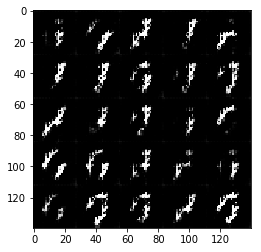

Epoch 1/2... Discriminator Loss: 1.3484... Generator Loss: 1.8324
Epoch 1/2... Discriminator Loss: 1.4723... Generator Loss: 1.3135
Epoch 1/2... Discriminator Loss: 1.3850... Generator Loss: 1.1749
Epoch 1/2... Discriminator Loss: 1.2732... Generator Loss: 0.8069
Epoch 1/2... Discriminator Loss: 2.1885... Generator Loss: 0.2020
Epoch 1/2... Discriminator Loss: 1.1989... Generator Loss: 0.5207
Epoch 1/2... Discriminator Loss: 2.2556... Generator Loss: 0.1902
Epoch 1/2... Discriminator Loss: 2.1798... Generator Loss: 0.2583
Epoch 1/2... Discriminator Loss: 1.4831... Generator Loss: 0.8688
Epoch 1/2... Discriminator Loss: 1.6318... Generator Loss: 0.4854


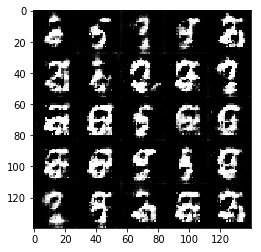

Epoch 1/2... Discriminator Loss: 1.3045... Generator Loss: 0.8052
Epoch 1/2... Discriminator Loss: 1.5314... Generator Loss: 0.4796
Epoch 1/2... Discriminator Loss: 1.2023... Generator Loss: 1.2303
Epoch 1/2... Discriminator Loss: 1.2820... Generator Loss: 1.2349
Epoch 1/2... Discriminator Loss: 1.6853... Generator Loss: 0.4225
Epoch 1/2... Discriminator Loss: 1.9425... Generator Loss: 0.2898
Epoch 1/2... Discriminator Loss: 2.1771... Generator Loss: 0.9226
Epoch 1/2... Discriminator Loss: 1.5284... Generator Loss: 0.5480
Epoch 1/2... Discriminator Loss: 1.2351... Generator Loss: 0.8859
Epoch 1/2... Discriminator Loss: 1.3194... Generator Loss: 1.3936


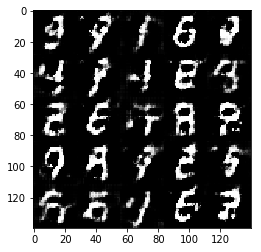

Epoch 1/2... Discriminator Loss: 1.6371... Generator Loss: 1.4536
Epoch 1/2... Discriminator Loss: 1.4824... Generator Loss: 0.4675
Epoch 1/2... Discriminator Loss: 1.3655... Generator Loss: 0.4269
Epoch 1/2... Discriminator Loss: 1.3253... Generator Loss: 1.2339
Epoch 1/2... Discriminator Loss: 1.6843... Generator Loss: 0.8051
Epoch 1/2... Discriminator Loss: 1.5169... Generator Loss: 0.7088
Epoch 1/2... Discriminator Loss: 1.2812... Generator Loss: 0.8482
Epoch 1/2... Discriminator Loss: 1.5792... Generator Loss: 1.2859
Epoch 1/2... Discriminator Loss: 1.9426... Generator Loss: 1.2860
Epoch 1/2... Discriminator Loss: 1.3767... Generator Loss: 0.6492


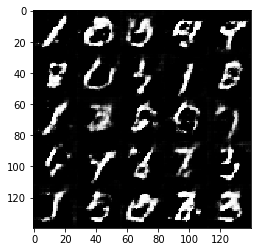

Epoch 1/2... Discriminator Loss: 1.6729... Generator Loss: 0.3714
Epoch 1/2... Discriminator Loss: 1.5242... Generator Loss: 0.8261
Epoch 1/2... Discriminator Loss: 1.6205... Generator Loss: 0.3705
Epoch 1/2... Discriminator Loss: 1.3596... Generator Loss: 0.9131
Epoch 1/2... Discriminator Loss: 1.4993... Generator Loss: 1.2661
Epoch 1/2... Discriminator Loss: 1.4109... Generator Loss: 0.5730
Epoch 1/2... Discriminator Loss: 1.5512... Generator Loss: 0.4627
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.9675
Epoch 1/2... Discriminator Loss: 1.4879... Generator Loss: 0.4721
Epoch 1/2... Discriminator Loss: 1.7211... Generator Loss: 0.2578


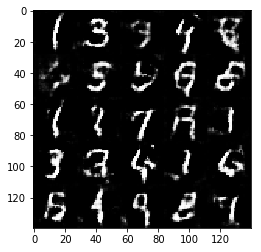

Epoch 1/2... Discriminator Loss: 1.6437... Generator Loss: 0.3362
Epoch 1/2... Discriminator Loss: 1.5182... Generator Loss: 0.4136
Epoch 1/2... Discriminator Loss: 1.5978... Generator Loss: 0.3295
Epoch 1/2... Discriminator Loss: 1.5079... Generator Loss: 0.4999
Epoch 1/2... Discriminator Loss: 1.6089... Generator Loss: 0.6636
Epoch 1/2... Discriminator Loss: 1.5958... Generator Loss: 0.4179
Epoch 1/2... Discriminator Loss: 2.2297... Generator Loss: 0.1611
Epoch 1/2... Discriminator Loss: 1.5539... Generator Loss: 0.3299
Epoch 1/2... Discriminator Loss: 1.4264... Generator Loss: 0.7665
Epoch 1/2... Discriminator Loss: 1.6791... Generator Loss: 1.1042


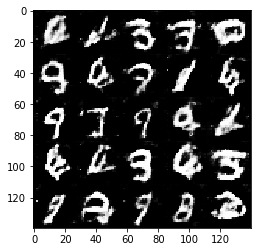

Epoch 1/2... Discriminator Loss: 1.5642... Generator Loss: 0.3788
Epoch 1/2... Discriminator Loss: 1.1261... Generator Loss: 0.9620
Epoch 1/2... Discriminator Loss: 2.3356... Generator Loss: 0.1282
Epoch 1/2... Discriminator Loss: 1.4599... Generator Loss: 0.5288
Epoch 1/2... Discriminator Loss: 1.3957... Generator Loss: 0.4715
Epoch 1/2... Discriminator Loss: 3.7378... Generator Loss: 0.0518
Epoch 1/2... Discriminator Loss: 1.6224... Generator Loss: 0.6100
Epoch 1/2... Discriminator Loss: 1.5834... Generator Loss: 0.3667
Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 0.9320
Epoch 1/2... Discriminator Loss: 2.2649... Generator Loss: 0.1370


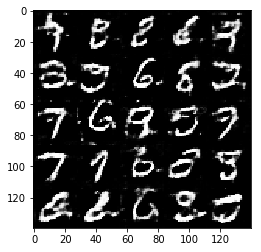

Epoch 1/2... Discriminator Loss: 1.2780... Generator Loss: 0.7925
Epoch 1/2... Discriminator Loss: 1.1001... Generator Loss: 0.8190
Epoch 1/2... Discriminator Loss: 1.4903... Generator Loss: 0.4378
Epoch 1/2... Discriminator Loss: 1.5230... Generator Loss: 0.3871
Epoch 1/2... Discriminator Loss: 1.4397... Generator Loss: 0.8000
Epoch 1/2... Discriminator Loss: 1.5540... Generator Loss: 1.2741
Epoch 1/2... Discriminator Loss: 1.6942... Generator Loss: 0.3215
Epoch 1/2... Discriminator Loss: 1.5014... Generator Loss: 0.4635
Epoch 1/2... Discriminator Loss: 1.6603... Generator Loss: 0.7102
Epoch 1/2... Discriminator Loss: 2.1017... Generator Loss: 0.9515


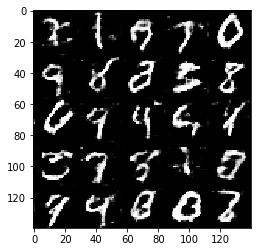

Epoch 1/2... Discriminator Loss: 1.6278... Generator Loss: 0.3862
Epoch 1/2... Discriminator Loss: 1.8273... Generator Loss: 0.2507
Epoch 1/2... Discriminator Loss: 2.1631... Generator Loss: 0.1724
Epoch 1/2... Discriminator Loss: 1.6883... Generator Loss: 0.3312
Epoch 1/2... Discriminator Loss: 1.5294... Generator Loss: 0.3338
Epoch 1/2... Discriminator Loss: 1.5483... Generator Loss: 0.3422
Epoch 1/2... Discriminator Loss: 1.4515... Generator Loss: 0.7155
Epoch 1/2... Discriminator Loss: 1.6802... Generator Loss: 0.4888
Epoch 1/2... Discriminator Loss: 1.4951... Generator Loss: 0.4767
Epoch 1/2... Discriminator Loss: 1.5067... Generator Loss: 0.4490


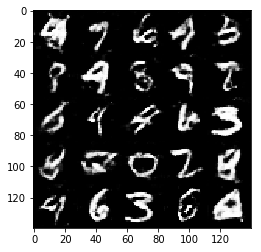

Epoch 1/2... Discriminator Loss: 1.7076... Generator Loss: 0.3318
Epoch 1/2... Discriminator Loss: 1.7751... Generator Loss: 0.3095
Epoch 1/2... Discriminator Loss: 1.7190... Generator Loss: 0.4298
Epoch 1/2... Discriminator Loss: 1.6145... Generator Loss: 0.3030
Epoch 1/2... Discriminator Loss: 1.7611... Generator Loss: 0.2448
Epoch 1/2... Discriminator Loss: 1.9514... Generator Loss: 0.1810
Epoch 1/2... Discriminator Loss: 1.4506... Generator Loss: 0.6028
Epoch 1/2... Discriminator Loss: 1.3778... Generator Loss: 0.5800
Epoch 1/2... Discriminator Loss: 1.9914... Generator Loss: 0.2032
Epoch 1/2... Discriminator Loss: 1.8417... Generator Loss: 0.2415


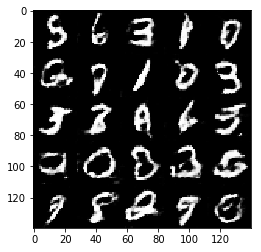

Epoch 1/2... Discriminator Loss: 1.4023... Generator Loss: 0.4476
Epoch 1/2... Discriminator Loss: 1.2945... Generator Loss: 0.5085
Epoch 1/2... Discriminator Loss: 1.4346... Generator Loss: 0.4407
Epoch 1/2... Discriminator Loss: 1.4945... Generator Loss: 0.4115
Epoch 1/2... Discriminator Loss: 1.3431... Generator Loss: 0.6616
Epoch 1/2... Discriminator Loss: 1.2423... Generator Loss: 0.5863
Epoch 1/2... Discriminator Loss: 1.6603... Generator Loss: 0.4532
Epoch 1/2... Discriminator Loss: 1.3112... Generator Loss: 0.5806
Epoch 1/2... Discriminator Loss: 1.2696... Generator Loss: 0.7974
Epoch 1/2... Discriminator Loss: 2.9097... Generator Loss: 0.0694


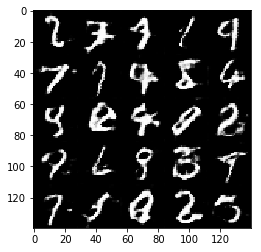

Epoch 1/2... Discriminator Loss: 1.2257... Generator Loss: 0.8149
Epoch 1/2... Discriminator Loss: 2.2896... Generator Loss: 0.1348
Epoch 1/2... Discriminator Loss: 1.3276... Generator Loss: 0.5863
Epoch 1/2... Discriminator Loss: 1.6737... Generator Loss: 0.2880
Epoch 1/2... Discriminator Loss: 1.4385... Generator Loss: 0.5323
Epoch 1/2... Discriminator Loss: 1.6463... Generator Loss: 0.6158
Epoch 1/2... Discriminator Loss: 1.6069... Generator Loss: 0.3099
Epoch 1/2... Discriminator Loss: 1.5602... Generator Loss: 0.6185
Epoch 1/2... Discriminator Loss: 1.6038... Generator Loss: 0.3332
Epoch 1/2... Discriminator Loss: 1.6717... Generator Loss: 0.2737


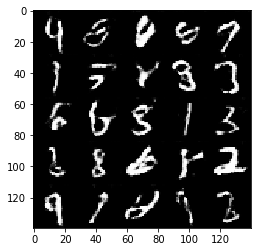

Epoch 1/2... Discriminator Loss: 2.0662... Generator Loss: 0.1773
Epoch 1/2... Discriminator Loss: 2.5655... Generator Loss: 0.1001
Epoch 1/2... Discriminator Loss: 1.3255... Generator Loss: 0.8488
Epoch 1/2... Discriminator Loss: 1.4235... Generator Loss: 0.4557
Epoch 1/2... Discriminator Loss: 1.3707... Generator Loss: 0.5449
Epoch 1/2... Discriminator Loss: 1.4114... Generator Loss: 0.5800
Epoch 1/2... Discriminator Loss: 1.6441... Generator Loss: 0.2935
Epoch 1/2... Discriminator Loss: 1.1809... Generator Loss: 0.7070
Epoch 1/2... Discriminator Loss: 1.3244... Generator Loss: 0.6145
Epoch 1/2... Discriminator Loss: 1.1673... Generator Loss: 0.6479


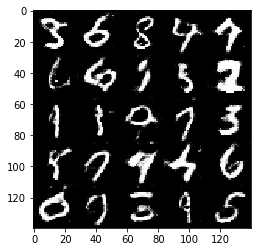

Epoch 1/2... Discriminator Loss: 2.0656... Generator Loss: 2.9617
Epoch 1/2... Discriminator Loss: 1.2603... Generator Loss: 0.5764
Epoch 1/2... Discriminator Loss: 1.0727... Generator Loss: 0.8970
Epoch 1/2... Discriminator Loss: 1.2457... Generator Loss: 0.6007
Epoch 1/2... Discriminator Loss: 1.6100... Generator Loss: 0.2876
Epoch 1/2... Discriminator Loss: 1.0136... Generator Loss: 1.3370
Epoch 1/2... Discriminator Loss: 2.4228... Generator Loss: 0.1280
Epoch 1/2... Discriminator Loss: 2.4139... Generator Loss: 0.1189
Epoch 1/2... Discriminator Loss: 1.3595... Generator Loss: 0.4368
Epoch 1/2... Discriminator Loss: 0.7998... Generator Loss: 1.1013


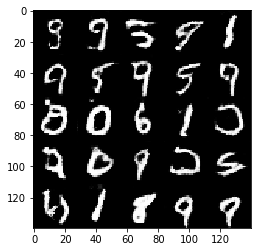

Epoch 1/2... Discriminator Loss: 1.7332... Generator Loss: 0.2726
Epoch 1/2... Discriminator Loss: 1.4980... Generator Loss: 1.1940
Epoch 1/2... Discriminator Loss: 1.4257... Generator Loss: 0.5557
Epoch 1/2... Discriminator Loss: 1.2562... Generator Loss: 0.5928
Epoch 1/2... Discriminator Loss: 1.2462... Generator Loss: 1.2291
Epoch 1/2... Discriminator Loss: 2.0042... Generator Loss: 0.1732
Epoch 1/2... Discriminator Loss: 1.1397... Generator Loss: 1.5187
Epoch 1/2... Discriminator Loss: 0.9681... Generator Loss: 0.9221
Epoch 1/2... Discriminator Loss: 1.5243... Generator Loss: 0.3398
Epoch 1/2... Discriminator Loss: 1.2632... Generator Loss: 0.4736


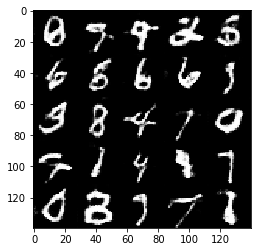

Epoch 1/2... Discriminator Loss: 1.6805... Generator Loss: 0.3303
Epoch 1/2... Discriminator Loss: 2.3494... Generator Loss: 0.1514
Epoch 1/2... Discriminator Loss: 1.6470... Generator Loss: 0.3096
Epoch 1/2... Discriminator Loss: 2.2859... Generator Loss: 0.1576
Epoch 1/2... Discriminator Loss: 1.2504... Generator Loss: 0.5757
Epoch 1/2... Discriminator Loss: 1.4179... Generator Loss: 0.8653
Epoch 1/2... Discriminator Loss: 1.6786... Generator Loss: 0.3023
Epoch 1/2... Discriminator Loss: 1.3536... Generator Loss: 0.3880
Epoch 1/2... Discriminator Loss: 1.6767... Generator Loss: 0.3002
Epoch 1/2... Discriminator Loss: 1.1905... Generator Loss: 0.6286


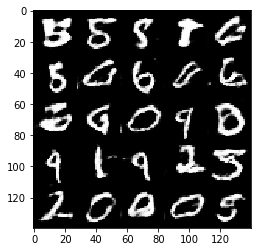

Epoch 1/2... Discriminator Loss: 1.5266... Generator Loss: 2.3109
Epoch 1/2... Discriminator Loss: 1.5973... Generator Loss: 0.3285
Epoch 1/2... Discriminator Loss: 1.3438... Generator Loss: 0.4968
Epoch 1/2... Discriminator Loss: 1.7413... Generator Loss: 0.3319
Epoch 1/2... Discriminator Loss: 1.5976... Generator Loss: 0.5488
Epoch 1/2... Discriminator Loss: 1.2449... Generator Loss: 0.7216
Epoch 1/2... Discriminator Loss: 1.0681... Generator Loss: 0.8579
Epoch 1/2... Discriminator Loss: 1.5974... Generator Loss: 0.3114
Epoch 1/2... Discriminator Loss: 2.0635... Generator Loss: 0.1932
Epoch 1/2... Discriminator Loss: 2.1204... Generator Loss: 0.1727


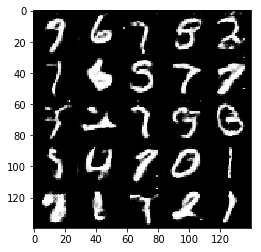

Epoch 1/2... Discriminator Loss: 1.9545... Generator Loss: 0.2295
Epoch 1/2... Discriminator Loss: 1.4200... Generator Loss: 0.3972
Epoch 1/2... Discriminator Loss: 1.7266... Generator Loss: 0.3149
Epoch 1/2... Discriminator Loss: 2.6850... Generator Loss: 0.1501
Epoch 1/2... Discriminator Loss: 1.3462... Generator Loss: 0.4347
Epoch 1/2... Discriminator Loss: 2.0374... Generator Loss: 0.1984
Epoch 1/2... Discriminator Loss: 1.8358... Generator Loss: 0.2653
Epoch 1/2... Discriminator Loss: 1.6169... Generator Loss: 0.3894
Epoch 1/2... Discriminator Loss: 1.7280... Generator Loss: 0.3000
Epoch 1/2... Discriminator Loss: 2.0858... Generator Loss: 0.2046


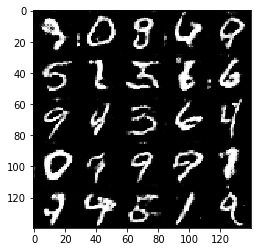

Epoch 1/2... Discriminator Loss: 0.6310... Generator Loss: 1.1515
Epoch 1/2... Discriminator Loss: 1.2332... Generator Loss: 0.6012
Epoch 1/2... Discriminator Loss: 2.3349... Generator Loss: 0.1397
Epoch 1/2... Discriminator Loss: 0.9435... Generator Loss: 0.8908
Epoch 1/2... Discriminator Loss: 1.6782... Generator Loss: 0.3165
Epoch 1/2... Discriminator Loss: 1.3875... Generator Loss: 0.9602
Epoch 1/2... Discriminator Loss: 1.5598... Generator Loss: 0.3318
Epoch 2/2... Discriminator Loss: 1.1177... Generator Loss: 0.8815
Epoch 2/2... Discriminator Loss: 1.9934... Generator Loss: 0.1896
Epoch 2/2... Discriminator Loss: 1.8927... Generator Loss: 0.2309


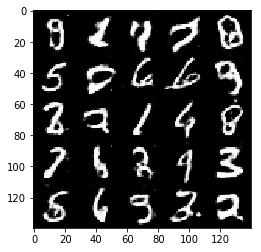

Epoch 2/2... Discriminator Loss: 1.0613... Generator Loss: 2.1156
Epoch 2/2... Discriminator Loss: 1.9294... Generator Loss: 0.2456
Epoch 2/2... Discriminator Loss: 1.3227... Generator Loss: 0.5788
Epoch 2/2... Discriminator Loss: 1.1405... Generator Loss: 0.6671
Epoch 2/2... Discriminator Loss: 1.9072... Generator Loss: 0.2471
Epoch 2/2... Discriminator Loss: 1.5379... Generator Loss: 0.3765
Epoch 2/2... Discriminator Loss: 1.4364... Generator Loss: 0.5888
Epoch 2/2... Discriminator Loss: 1.8156... Generator Loss: 0.2591
Epoch 2/2... Discriminator Loss: 1.8558... Generator Loss: 0.2934
Epoch 2/2... Discriminator Loss: 2.3061... Generator Loss: 1.3370


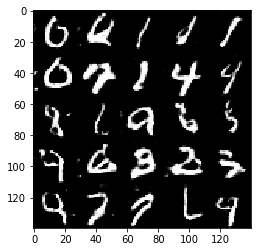

Epoch 2/2... Discriminator Loss: 1.4929... Generator Loss: 0.3723
Epoch 2/2... Discriminator Loss: 2.9317... Generator Loss: 4.4968
Epoch 2/2... Discriminator Loss: 0.8918... Generator Loss: 1.4368
Epoch 2/2... Discriminator Loss: 1.1651... Generator Loss: 0.6564
Epoch 2/2... Discriminator Loss: 1.1371... Generator Loss: 0.7464
Epoch 2/2... Discriminator Loss: 1.2159... Generator Loss: 1.0071
Epoch 2/2... Discriminator Loss: 1.0872... Generator Loss: 0.7324
Epoch 2/2... Discriminator Loss: 2.2615... Generator Loss: 0.1556
Epoch 2/2... Discriminator Loss: 1.4648... Generator Loss: 0.4105
Epoch 2/2... Discriminator Loss: 0.9114... Generator Loss: 0.9059


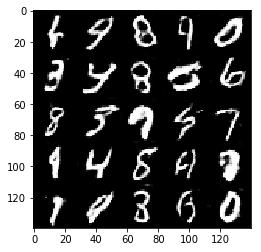

Epoch 2/2... Discriminator Loss: 2.0894... Generator Loss: 0.2086
Epoch 2/2... Discriminator Loss: 1.8284... Generator Loss: 0.2812
Epoch 2/2... Discriminator Loss: 1.5678... Generator Loss: 0.3500
Epoch 2/2... Discriminator Loss: 1.8693... Generator Loss: 0.2424
Epoch 2/2... Discriminator Loss: 1.7133... Generator Loss: 0.3618
Epoch 2/2... Discriminator Loss: 1.6648... Generator Loss: 0.3941
Epoch 2/2... Discriminator Loss: 1.8666... Generator Loss: 0.2835
Epoch 2/2... Discriminator Loss: 2.6383... Generator Loss: 0.1333
Epoch 2/2... Discriminator Loss: 2.5555... Generator Loss: 0.1241
Epoch 2/2... Discriminator Loss: 1.8448... Generator Loss: 0.2333


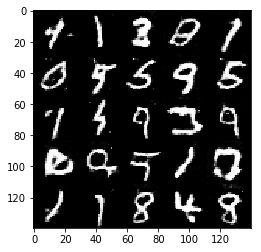

Epoch 2/2... Discriminator Loss: 0.9825... Generator Loss: 0.8255
Epoch 2/2... Discriminator Loss: 1.6666... Generator Loss: 0.3260
Epoch 2/2... Discriminator Loss: 2.1671... Generator Loss: 0.1704
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 0.5050
Epoch 2/2... Discriminator Loss: 1.3708... Generator Loss: 0.4300
Epoch 2/2... Discriminator Loss: 0.9220... Generator Loss: 1.1425
Epoch 2/2... Discriminator Loss: 1.2234... Generator Loss: 2.0055
Epoch 2/2... Discriminator Loss: 1.2044... Generator Loss: 1.0286
Epoch 2/2... Discriminator Loss: 1.5319... Generator Loss: 0.3859
Epoch 2/2... Discriminator Loss: 1.5994... Generator Loss: 0.4164


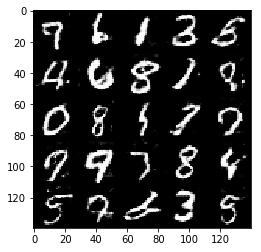

Epoch 2/2... Discriminator Loss: 2.3016... Generator Loss: 0.2044
Epoch 2/2... Discriminator Loss: 1.2693... Generator Loss: 0.5371
Epoch 2/2... Discriminator Loss: 1.9984... Generator Loss: 0.2793
Epoch 2/2... Discriminator Loss: 3.5270... Generator Loss: 0.0606
Epoch 2/2... Discriminator Loss: 0.9919... Generator Loss: 1.7460
Epoch 2/2... Discriminator Loss: 1.1536... Generator Loss: 1.6472
Epoch 2/2... Discriminator Loss: 2.3265... Generator Loss: 0.1736
Epoch 2/2... Discriminator Loss: 1.9234... Generator Loss: 0.2595
Epoch 2/2... Discriminator Loss: 1.7336... Generator Loss: 0.3230
Epoch 2/2... Discriminator Loss: 1.8955... Generator Loss: 0.2365


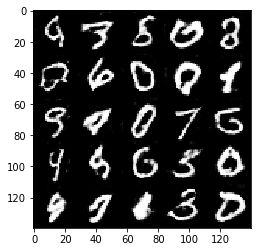

Epoch 2/2... Discriminator Loss: 2.3647... Generator Loss: 0.1759
Epoch 2/2... Discriminator Loss: 2.1849... Generator Loss: 0.1994
Epoch 2/2... Discriminator Loss: 1.7458... Generator Loss: 0.2934
Epoch 2/2... Discriminator Loss: 1.3275... Generator Loss: 1.4276
Epoch 2/2... Discriminator Loss: 1.3585... Generator Loss: 0.5093
Epoch 2/2... Discriminator Loss: 1.9940... Generator Loss: 0.2222
Epoch 2/2... Discriminator Loss: 1.8339... Generator Loss: 0.2680
Epoch 2/2... Discriminator Loss: 1.6583... Generator Loss: 0.3775
Epoch 2/2... Discriminator Loss: 2.0853... Generator Loss: 0.2301
Epoch 2/2... Discriminator Loss: 0.9516... Generator Loss: 1.0938


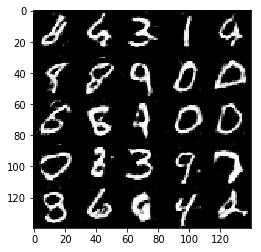

Epoch 2/2... Discriminator Loss: 1.8074... Generator Loss: 0.2798
Epoch 2/2... Discriminator Loss: 1.3081... Generator Loss: 0.4612
Epoch 2/2... Discriminator Loss: 1.2161... Generator Loss: 0.6564
Epoch 2/2... Discriminator Loss: 1.3801... Generator Loss: 0.4163
Epoch 2/2... Discriminator Loss: 0.8733... Generator Loss: 1.8433
Epoch 2/2... Discriminator Loss: 1.8206... Generator Loss: 0.2428
Epoch 2/2... Discriminator Loss: 1.0709... Generator Loss: 0.6784
Epoch 2/2... Discriminator Loss: 1.1017... Generator Loss: 0.6657
Epoch 2/2... Discriminator Loss: 1.6019... Generator Loss: 0.3646
Epoch 2/2... Discriminator Loss: 1.8758... Generator Loss: 0.2696


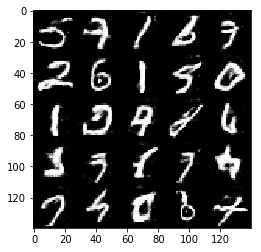

Epoch 2/2... Discriminator Loss: 1.8349... Generator Loss: 0.2756
Epoch 2/2... Discriminator Loss: 1.9589... Generator Loss: 0.2064
Epoch 2/2... Discriminator Loss: 2.1645... Generator Loss: 0.2529
Epoch 2/2... Discriminator Loss: 2.1243... Generator Loss: 0.2140
Epoch 2/2... Discriminator Loss: 4.1414... Generator Loss: 0.0262
Epoch 2/2... Discriminator Loss: 2.0795... Generator Loss: 0.2696
Epoch 2/2... Discriminator Loss: 1.2727... Generator Loss: 0.5171
Epoch 2/2... Discriminator Loss: 2.4646... Generator Loss: 0.1553
Epoch 2/2... Discriminator Loss: 2.6761... Generator Loss: 0.1071
Epoch 2/2... Discriminator Loss: 0.9472... Generator Loss: 1.4194


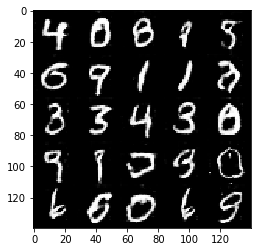

Epoch 2/2... Discriminator Loss: 2.5772... Generator Loss: 0.1445
Epoch 2/2... Discriminator Loss: 0.7897... Generator Loss: 1.2556
Epoch 2/2... Discriminator Loss: 1.1236... Generator Loss: 0.5891
Epoch 2/2... Discriminator Loss: 1.3764... Generator Loss: 0.4598
Epoch 2/2... Discriminator Loss: 1.2512... Generator Loss: 0.5938
Epoch 2/2... Discriminator Loss: 2.1273... Generator Loss: 0.1989
Epoch 2/2... Discriminator Loss: 4.0246... Generator Loss: 0.0329
Epoch 2/2... Discriminator Loss: 1.1204... Generator Loss: 0.6337
Epoch 2/2... Discriminator Loss: 1.9589... Generator Loss: 0.2945
Epoch 2/2... Discriminator Loss: 2.4253... Generator Loss: 0.1795


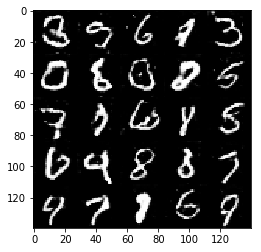

Epoch 2/2... Discriminator Loss: 2.1993... Generator Loss: 0.2169
Epoch 2/2... Discriminator Loss: 2.3097... Generator Loss: 0.2009
Epoch 2/2... Discriminator Loss: 1.5787... Generator Loss: 0.3302
Epoch 2/2... Discriminator Loss: 1.8025... Generator Loss: 0.3169
Epoch 2/2... Discriminator Loss: 0.9375... Generator Loss: 1.1030
Epoch 2/2... Discriminator Loss: 0.9124... Generator Loss: 1.3747
Epoch 2/2... Discriminator Loss: 2.0986... Generator Loss: 0.2667
Epoch 2/2... Discriminator Loss: 1.5425... Generator Loss: 0.3562
Epoch 2/2... Discriminator Loss: 1.6867... Generator Loss: 0.4397
Epoch 2/2... Discriminator Loss: 4.4972... Generator Loss: 5.3142


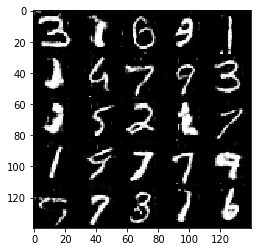

Epoch 2/2... Discriminator Loss: 1.3588... Generator Loss: 1.6066
Epoch 2/2... Discriminator Loss: 0.8346... Generator Loss: 0.9584
Epoch 2/2... Discriminator Loss: 1.7319... Generator Loss: 0.2814
Epoch 2/2... Discriminator Loss: 1.5480... Generator Loss: 0.4317
Epoch 2/2... Discriminator Loss: 2.4424... Generator Loss: 0.1412
Epoch 2/2... Discriminator Loss: 1.7754... Generator Loss: 0.3247
Epoch 2/2... Discriminator Loss: 0.8784... Generator Loss: 0.8839
Epoch 2/2... Discriminator Loss: 1.5812... Generator Loss: 0.3362
Epoch 2/2... Discriminator Loss: 1.1474... Generator Loss: 0.7834
Epoch 2/2... Discriminator Loss: 2.2866... Generator Loss: 0.1703


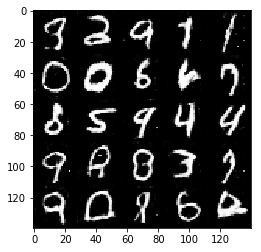

Epoch 2/2... Discriminator Loss: 1.6192... Generator Loss: 0.3374
Epoch 2/2... Discriminator Loss: 2.1828... Generator Loss: 0.2187
Epoch 2/2... Discriminator Loss: 1.2351... Generator Loss: 0.5750
Epoch 2/2... Discriminator Loss: 1.2647... Generator Loss: 0.5968
Epoch 2/2... Discriminator Loss: 0.3532... Generator Loss: 1.4846
Epoch 2/2... Discriminator Loss: 1.7022... Generator Loss: 0.2756
Epoch 2/2... Discriminator Loss: 2.6523... Generator Loss: 0.1654
Epoch 2/2... Discriminator Loss: 3.9996... Generator Loss: 0.0431
Epoch 2/2... Discriminator Loss: 1.7105... Generator Loss: 0.3399
Epoch 2/2... Discriminator Loss: 0.9360... Generator Loss: 0.9256


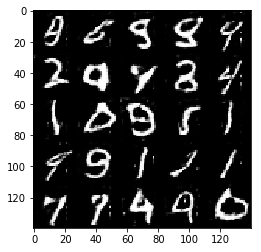

Epoch 2/2... Discriminator Loss: 2.5758... Generator Loss: 0.1253
Epoch 2/2... Discriminator Loss: 2.8272... Generator Loss: 0.1085
Epoch 2/2... Discriminator Loss: 1.2049... Generator Loss: 0.5684
Epoch 2/2... Discriminator Loss: 1.4467... Generator Loss: 0.4029
Epoch 2/2... Discriminator Loss: 0.5929... Generator Loss: 1.3547
Epoch 2/2... Discriminator Loss: 1.2463... Generator Loss: 1.0270
Epoch 2/2... Discriminator Loss: 2.0019... Generator Loss: 0.3140
Epoch 2/2... Discriminator Loss: 0.8497... Generator Loss: 0.8689
Epoch 2/2... Discriminator Loss: 0.8177... Generator Loss: 1.1485
Epoch 2/2... Discriminator Loss: 1.4289... Generator Loss: 0.4331


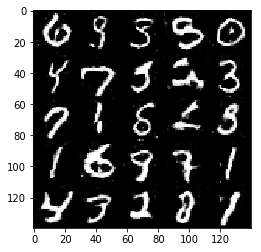

Epoch 2/2... Discriminator Loss: 2.1747... Generator Loss: 0.1929
Epoch 2/2... Discriminator Loss: 2.1921... Generator Loss: 4.2551
Epoch 2/2... Discriminator Loss: 1.3681... Generator Loss: 0.4057
Epoch 2/2... Discriminator Loss: 1.3070... Generator Loss: 0.6588
Epoch 2/2... Discriminator Loss: 1.1183... Generator Loss: 0.5809
Epoch 2/2... Discriminator Loss: 1.5806... Generator Loss: 0.3818
Epoch 2/2... Discriminator Loss: 2.4540... Generator Loss: 0.1390
Epoch 2/2... Discriminator Loss: 2.6155... Generator Loss: 0.1195
Epoch 2/2... Discriminator Loss: 1.4157... Generator Loss: 0.4460
Epoch 2/2... Discriminator Loss: 1.9795... Generator Loss: 0.2427


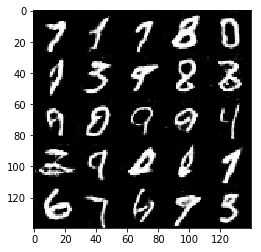

Epoch 2/2... Discriminator Loss: 0.7320... Generator Loss: 1.0325
Epoch 2/2... Discriminator Loss: 1.9083... Generator Loss: 0.2423
Epoch 2/2... Discriminator Loss: 0.9206... Generator Loss: 0.7992
Epoch 2/2... Discriminator Loss: 0.8700... Generator Loss: 1.2937
Epoch 2/2... Discriminator Loss: 0.8985... Generator Loss: 2.2254
Epoch 2/2... Discriminator Loss: 0.7989... Generator Loss: 0.9226
Epoch 2/2... Discriminator Loss: 0.8782... Generator Loss: 0.9684
Epoch 2/2... Discriminator Loss: 2.0145... Generator Loss: 0.3409
Epoch 2/2... Discriminator Loss: 2.1857... Generator Loss: 0.1779
Epoch 2/2... Discriminator Loss: 1.4031... Generator Loss: 0.5851


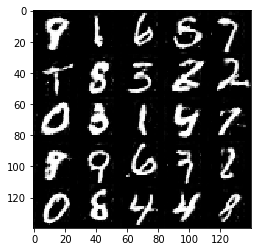

Epoch 2/2... Discriminator Loss: 2.6631... Generator Loss: 0.1191
Epoch 2/2... Discriminator Loss: 2.6350... Generator Loss: 0.1344
Epoch 2/2... Discriminator Loss: 1.9465... Generator Loss: 0.2211
Epoch 2/2... Discriminator Loss: 1.9110... Generator Loss: 0.3485
Epoch 2/2... Discriminator Loss: 3.2589... Generator Loss: 0.0621
Epoch 2/2... Discriminator Loss: 1.5055... Generator Loss: 0.3636
Epoch 2/2... Discriminator Loss: 3.2241... Generator Loss: 0.0775
Epoch 2/2... Discriminator Loss: 1.8386... Generator Loss: 0.2760
Epoch 2/2... Discriminator Loss: 2.5863... Generator Loss: 0.1705
Epoch 2/2... Discriminator Loss: 1.7793... Generator Loss: 0.2968


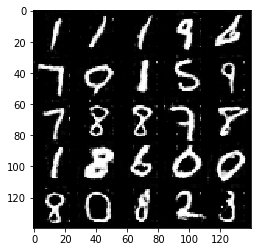

Epoch 2/2... Discriminator Loss: 1.9088... Generator Loss: 0.3814
Epoch 2/2... Discriminator Loss: 2.8018... Generator Loss: 0.1587
Epoch 2/2... Discriminator Loss: 0.9247... Generator Loss: 0.9112
Epoch 2/2... Discriminator Loss: 1.5423... Generator Loss: 1.7755
Epoch 2/2... Discriminator Loss: 2.8666... Generator Loss: 0.0945
Epoch 2/2... Discriminator Loss: 2.5150... Generator Loss: 0.1722
Epoch 2/2... Discriminator Loss: 1.3097... Generator Loss: 0.6987
Epoch 2/2... Discriminator Loss: 1.3135... Generator Loss: 0.5678
Epoch 2/2... Discriminator Loss: 1.6264... Generator Loss: 0.3242
Epoch 2/2... Discriminator Loss: 2.6612... Generator Loss: 0.1692


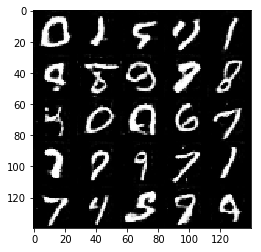

Epoch 2/2... Discriminator Loss: 3.7262... Generator Loss: 0.0554
Epoch 2/2... Discriminator Loss: 1.0806... Generator Loss: 0.7157
Epoch 2/2... Discriminator Loss: 1.2472... Generator Loss: 2.2382
Epoch 2/2... Discriminator Loss: 1.4310... Generator Loss: 0.5155
Epoch 2/2... Discriminator Loss: 2.1139... Generator Loss: 0.1925
Epoch 2/2... Discriminator Loss: 2.0525... Generator Loss: 0.2252
Epoch 2/2... Discriminator Loss: 1.2720... Generator Loss: 0.5787
Epoch 2/2... Discriminator Loss: 2.0831... Generator Loss: 0.2028
Epoch 2/2... Discriminator Loss: 2.7377... Generator Loss: 0.1357
Epoch 2/2... Discriminator Loss: 2.4379... Generator Loss: 0.1688


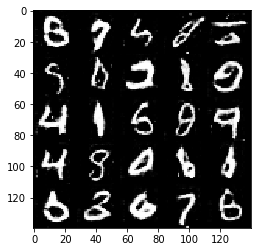

Epoch 2/2... Discriminator Loss: 1.0326... Generator Loss: 2.9914
Epoch 2/2... Discriminator Loss: 2.4933... Generator Loss: 0.1439
Epoch 2/2... Discriminator Loss: 1.2971... Generator Loss: 0.5094
Epoch 2/2... Discriminator Loss: 1.9254... Generator Loss: 0.2352
Epoch 2/2... Discriminator Loss: 0.8141... Generator Loss: 1.3412


In [14]:
batch_size = 32
z_dim = 100
learning_rate = 0.002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

In [ ]:
batch_size = 128
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.